In [32]:
import os, sys
import pandas as pd
import numpy as np
import datetime as dt
from pprint import pprint
import csv
import itertools as it
from prettytable import PrettyTable
import matplotlib.pylab as plt
import seaborn as sns
import portion as P
from collections import namedtuple
import math
import ast

DataFrame = namedtuple('DataFrame', 'filename, df', defaults=tuple([None]*2))

pdir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # for jupyter-notebook
sys.path.insert(1, pdir)
from myutils import *

%config InlineBackend.figure_format = 'retina'  # 提高 jupyter notebook 的圖形顯示解析度
# plt.style.use('ggplot')

pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

def set_data(df, mode='pcap', tz=0):
    if mode == 'pcap':
        df['seq'] = df['seq'].astype('Int32')
        # df['rpkg'] = df['rpkg'].astype('Int8')
        df['frame_id'] = df['frame_id'].astype('Int32')
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['xmit_time'] = pd.to_datetime(df['xmit_time'])
        df['arr_time'] = pd.to_datetime(df['arr_time'])
        df['Timestamp_epoch'] = df['Timestamp_epoch'].astype('float32')
        df['xmit_time_epoch'] = df['xmit_time_epoch'].astype('float32')
        df['arr_time_epoch'] = df['arr_time_epoch'].astype('float32')
        df['lost'] = df['lost'].astype('boolean')
        df['excl'] = df['excl'].astype('boolean')
        df['latency'] = df['latency'].astype('float32')
    # E-UTRA & NR
    def nr_serv_cel(row):
        pos = row.serv_cel_pos
        if pos == 255:
            return 65535, -160, -50
        else:
            return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']
    if mode == 'lte':
        df = df.rename(columns={
            'RSRP(dBm)': 'RSRP',
            'RSRQ(dB)': 'RSRQ',
            'Serving Cell Index': 'serv_cel_index',
            'Number of Neighbor Cells': 'num_neigh_cels',
            'Number of Detected Cells': 'num_cels',
            }).reindex(['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                        'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0',
                        *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
        df.loc[df['serv_cel_index'] == '(MI)Unknown', 'serv_cel_index'] = '3_SCell'
        df['num_cels'] = df['num_neigh_cels'] + 1
        ## set dtypes
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df['type_id'] = df['type_id'].astype('category')
        df['serv_cel_index'] = df['serv_cel_index'].astype('category')
        df['EARFCN'] = df['EARFCN'].astype('Int32')
        df['NR_ARFCN'] = df['NR_ARFCN'].astype('Int32')
        df['num_cels'] = df['num_cels'].astype('UInt8')
        df['num_neigh_cels'] = df['num_neigh_cels'].astype('UInt8')
        df['serv_cel_pos'] = df['serv_cel_pos'].astype('UInt8')
        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP','RSRQ')):
                df[tag] = df[tag].astype('float32')
    if mode == 'nr':
        if df.empty:
            df = pd.DataFrame(columns=['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                                       'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0'])
        else:
            df = df.rename(columns={
                'Raster ARFCN': 'NR_ARFCN',
                'Serving Cell Index': 'serv_cel_pos',
                'Num Cells': 'num_cels',
                }).reindex(['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                            'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0',
                            *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
            df.loc[df['serv_cel_pos'] != 255, 'serv_cel_index'] = 'PSCell'
            df[['PCI','RSRP','RSRQ']] = df.apply(nr_serv_cel, axis=1, result_type='expand')
            df.loc[df['serv_cel_pos'] == 255, 'num_neigh_cels'] = df['num_cels']
            df.loc[df['serv_cel_pos'] != 255, 'num_neigh_cels'] = df['num_cels'] - 1
        ## set dtypes
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df['type_id'] = df['type_id'].astype('category')
        df['serv_cel_index'] = df['serv_cel_index'].astype('category')
        df['EARFCN'] = df['EARFCN'].astype('Int32')
        df['NR_ARFCN'] = df['NR_ARFCN'].astype('Int32')
        df['num_cels'] = df['num_cels'].astype('UInt8')
        df['num_neigh_cels'] = df['num_neigh_cels'].astype('UInt8')
        df['serv_cel_pos'] = df['serv_cel_pos'].astype('UInt8')
        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP','RSRQ')):
                df[tag] = df[tag].astype('float32')
    return df

In [33]:
# root = '/home/wmnlab/D/database'
root = '/Users/jackbedford/Desktop/MOXA/Code/data'
paths = [s for s in os.listdir(root) if s.startswith('202') and os.path.isdir(os.path.join(root, s))]

md_files = []

for date_dir in paths:
    datedir = os.path.join(root, date_dir)
    md_file = [os.path.join(datedir, s) for s in os.listdir(datedir) if s.endswith('.md')]
    md_files += md_file

md_files = sorted(md_files)

# Select dates
# md_files = md_files[:-1]
# md_files = [md_files[2]]
md_files = [s for s in md_files if '05-04' not in s and '05-07' not in s]
# md_files = md_files[:5]

pprint(md_files)

['/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/2023-03-16.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-26/2023-03-26.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/2023-04-01.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/2023-04-10.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-17/2023-04-17.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-15/2023-05-15.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-24/2023-05-24.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-26/2023-05-26.md']


In [34]:
class Experiment():
    
    def __init__(self, dir_name, setting):
        
        self.dir_name = dir_name
        self.setting = setting
        
    def __repr__(self):
        return f'{self.dir_name} -> {self.setting}'

exp_list = []

for md_file in md_files:
    
    md_f = open(md_file, 'r')
    lines = []
    l = md_f.readline()[:-1]
    
    while l:
        
        if l == '#endif':
            break
        lines.append(l)
        l = md_f.readline()[:-1]
        
    md_f.close()
    
    for exp, dic in zip(lines[::2], lines[1::2]):
        
        dictionary = ast.literal_eval(dic)
        parent_dir = os.path.dirname(md_file)
        experiment = Experiment(dir_name = os.path.join(parent_dir, exp), setting=dictionary)
        exp_list.append(experiment)
        
pprint(exp_list)

[/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q -> {'qc00': 'B1', 'qc02': 'B7', 'qc03': 'B8'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-26/Bandlock_Udp_All_RM500Q -> {'qc00': 'B3', 'qc02': 'B7', 'qc03': 'B8'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q -> {'qc00': 'B1B3', 'qc01': 'B1B8', 'qc02': 'LTE', 'qc03': 'All'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_B1_B3_B7_B8_RM500Q -> {'qc00': 'B1', 'qc01': 'B3', 'qc02': 'B7', 'qc03': 'B8'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/Experiment1 -> {'qc00': 'All', 'qc01': 'All', 'qc02': 'All', 'qc03': 'All'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/Experiment2 -> {'qc00': 'B1', 'qc01': 'B3', 'qc02': 'B7', 'qc03': 'B8'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/Experiment3 -> {'qc00': 'LTE', 'qc01': 'All', 'qc02': 'B7B8', 'qc03': 'B7'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023

In [35]:
# Set band parameters
schms = ['All','LTE','B1','B3','B7','B8','B1B3','B1B7','B1B8','B3B7','B3B8','B7B8','B3B7B8']

rrc_dict = {}
nr_dict = {}
lte_dict = {}
ul_pkt_dict = {}
dl_pkt_dict = {}

for schm in schms:
        
    path_list = []
    
    for exp in exp_list:
        
        reverse_dict = {v:k for k, v in exp.setting.items()}
        
        try:
            dev = reverse_dict[schm]
        except:
            # print('warning:', schm)
            continue
        
        device_dir = os.path.join(exp.dir_name, dev)
        
        for trace in os.listdir(device_dir):
        
            if '#' not in trace:
                continue
        
            trace_dir = os.path.join(device_dir, trace, 'data')
            path_list.append(trace_dir)

    path_list = sorted(path_list)

    rrc_list, nr_list, lte_list, ul_pkt_list, dl_pkt_list = [], [], [], [], []

    for path in path_list:
        rrc_list += [os.path.join(path, 'handover_info_list.pkl')]
        # rrc_list += [os.path.join(path, s) for s in os.listdir(path) if s.endswith('_rrc.pkl')]
        nr_list += [os.path.join(path, s) for s in os.listdir(path) if s.endswith('_nr_ml1.pkl')]
        lte_list += [os.path.join(path, s) for s in os.listdir(path) if s.endswith('_ml1.pkl') and not s.endswith('_nr_ml1.pkl')]
        ul_pkt_list += [os.path.join(path, 'udp_uplk_loss_latency.pkl')]
        dl_pkt_list += [os.path.join(path, 'udp_dnlk_loss_latency.pkl')]
    
    rrc_dict[schm] = rrc_list
    nr_dict[schm] = nr_list
    lte_dict[schm] = lte_list
    ul_pkt_dict[schm] = ul_pkt_list
    dl_pkt_dict[schm] = dl_pkt_list

In [36]:
rrc_dict['All'] = rrc_dict['All'] + rrc_dict['B3B7B8']
nr_dict['All'] = nr_dict['All'] + nr_dict['B3B7B8']
lte_dict['All'] = lte_dict['All'] + lte_dict['B3B7B8']
ul_pkt_dict['All'] = ul_pkt_dict['All'] + ul_pkt_dict['B3B7B8']
dl_pkt_dict['All'] = dl_pkt_dict['All'] + dl_pkt_dict['B3B7B8']

schms.remove('B3B7B8')

del rrc_dict['B3B7B8']
del nr_dict['B3B7B8']
del lte_dict['B3B7B8']
del ul_pkt_dict['B3B7B8']
del dl_pkt_dict['B3B7B8']

In [37]:
# pprint(schms)

## Label Handover

In [38]:
## Downlink
dl_ImpactScope = {
    'LTE_HO': (1.4, 0.75),
    'MN_HO': (2.8, 2.2),
    'SN_HO': (6, 6.3),
    'SN_Setup': (0.5, 2),
    'SN_Rel': (0.4, 0.2),
    'SN_Rel_MN_HO': (0.6, 1),
    'SCG_Failure_t310-Expiry (0)': (3.2, 1.2),
    'SCG_Failure_randomAccessProblem (1)': (2, 2),
    'SCG_Failure_rlc-MaxNumRetx (2)': (2, 2),
    'SCG_Failure_synchReconfigFailureSCG (3)': (0.1, 0.1),
    'MCG_Failure_reconfigurationFailure (0)': (2, 2),
    'MCG_Failure_handoverFailure (1)': (0.75, 1.25),
    'MCG_Failure_otherFailure (2)': (5.6, 1.7),
    'NAS_Recovery_reconfigurationFailure (0)': (2, 2),
    'NAS_Recovery_handoverFailure (1)': (0.65, 0.7),
    'NAS_Recovery_otherFailure (2)': (3.6, 1.85),
}

## Uplink
ul_ImpactScope = {
    'LTE_HO': (2, 2),
    'MN_HO': (1, 1.7),
    'SN_HO': (2, 2),
    'SN_Setup': (0.5, 2),
    'SN_Rel': (0.2, 1.5),
    'SN_Rel_MN_HO': (1.2 , 0.85),
    'SCG_Failure_t310-Expiry (0)': (2, 1.6),
    'SCG_Failure_randomAccessProblem (1)': (0.1, 0.1),
    'SCG_Failure_rlc-MaxNumRetx (2)': (1.5, 0.1),
    'SCG_Failure_synchReconfigFailureSCG (3)': (0.1, 0.1),
    'MCG_Failure_reconfigurationFailure (0)': (2, 2),
    'MCG_Failure_handoverFailure (1)': (0.65, 0.15),
    'MCG_Failure_otherFailure (2)': (5, 1.5),
    'NAS_Recovery_reconfigurationFailure (0)': (2, 2),
    'NAS_Recovery_handoverFailure (1)': (0.1, 0.4),
    'NAS_Recovery_otherFailure (2)': (1.65, 1.7),
}

In [39]:
sorter = ['LTE_HO','MN_HO','SN_HO','MNSN_HO','SN_Rel','SN_Setup','SN_Rel_MN_HO','SN_Setup_MN_HO',
          'SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)',
          'SCG_Failure_scg-ReconfigFailure (4)','SCG_Failure_srb3-IntegrityFailure (5)','SCG_Failure_other-r16 (6)',
          'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
          'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']

def cut_head_tail(df_HO, df, mode='ul'):
    if mode == 'ul':
        start = df.iloc[0].xmit_time
        stop = df.iloc[-1].xmit_time
        df_HO = df_HO.query('Timestamp >= @start & Timestamp <= @stop').copy().reset_index(drop=True)
    if mode == 'dl':
        start = df.iloc[0].arr_time
        stop = df.iloc[-1].arr_time
        df_HO = df_HO.query('Timestamp >= @start & Timestamp <= @stop').copy().reset_index(drop=True)
    return df_HO

def is_disjoint(set1, set2):
    """
    Check if two sets are disjoint.
    """
    return (set1 & set2).empty

def is_disjoint_dict(E):
    test_intv = P.empty()
    for key, val in E.items():
        # print(key)
        for intv in val:
            if is_disjoint(test_intv, intv.interval):
                test_intv = test_intv | intv.interval
            else:
                print(key, intv.index)
                return False
    return True

def interp(x, y, ratio):
    """
    Interpolation

    Args:
        x, y (datetime.datetime): x < y
        ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
    Returns:
        (datetime.datetime): breakpoint of interpolation
    """
    return x + (y - x) * ratio

def get_ho_interval(df, sec=(1, 3), ratio=0.5,
                 ignored=['Conn_Setup','Conn_Rel'],
                 handover=['LTE_HO','MN_HO','SN_HO','SN_Setup','SN_Rel','SN_Rel_MN_HO'],
                 linkfailure=['SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)',
                              'SCG_Failure_scg-ReconfigFailure (4)','SCG_Failure_srb3-IntegrityFailure (5)','SCG_Failure_other-r16 (6)',
                              'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
                              'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)'],
                 ImpactScope=dl_ImpactScope):
    
    HO_INTV = namedtuple('HO_INTV', 'index, interval, state1, state2, st_scel, cause, interrupt, \
                                     ePCI, earfcn, nrPCI, ePCI1, earfcn1, nrPCI1', defaults=tuple([None]*12))
    
    def ignore_col(row):
        if row.ho_type in ignored:
            return False
        else:
            return True
    df = df[df.apply(ignore_col, axis=1)].reset_index(drop=True)
    
    column_names = []
    for type_name in handover + linkfailure:
        column_names += ["before_{}".format(type_name), "during_{}".format(type_name), "after_{}".format(type_name)]
    E = { col:[] for col in column_names }
    
    for i, row in df.iterrows():
        prior_row = df.iloc[i-1] if i != 0 else None
        post_row = df.iloc[i+1] if i != len(df)-1 else None
        ### peek the next event
        if i != len(df)-1 and pd.notna(row.end) and row.end > post_row.start:
            print(i, row.start, row.end, row.ho_type, row.cause)
            print(i+1, post_row.start, post_row.end, post_row.ho_type, post_row.cause)
            continue
        ### peri_interval
        if pd.isna(row.end):
            peri_interval = P.singleton(row.start)
        else:
            peri_interval = P.closed(row.start, row.end)
        ### prior_interval
        type_name = row.ho_type if row.ho_type not in ['SCG_Failure','MCG_Failure','NAS_Recovery'] else row.ho_type + '_' + row.cause
        C = row.start - pd.Timedelta(seconds=ImpactScope[type_name][0])
        D = row.start
        prior_interval = P.closedopen(C, D)
        if ratio != None and i != 0:
            type_name = prior_row.ho_type if prior_row.ho_type not in ['SCG_Failure','MCG_Failure','NAS_Recovery'] else prior_row.ho_type + '_' + prior_row.cause
            A = max(prior_row.start, prior_row.end)
            B = max(prior_row.start, prior_row.end) + pd.Timedelta(seconds=ImpactScope[type_name][1])
            if P.openclosed(A, B).overlaps(prior_interval):
                # print("Overlaps with the previous!")
                bkp = interp(C, B, ratio)
                bkp = max(bkp, A)  # to avoid the breakpoint overlaps the previous event's duration
                # bkp = min(max(bkp, A), D)  # 我不侵犯到其他任何人，代表其他人也不會侵犯到我！
                prior_interval = P.closedopen(bkp, D)
                if A in prior_interval:
                    prior_interval = P.open(bkp, D)
                # blindly set as open inverval is fine, but may miss one point.
        ### post_interval
        type_name = row.ho_type if row.ho_type not in ['SCG_Failure','MCG_Failure','NAS_Recovery'] else row.ho_type + '_' + row.cause
        C = row.end
        D = row.end + pd.Timedelta(seconds=ImpactScope[type_name][1])
        post_interval = P.openclosed(C, D)
        if ratio != None and i != len(df)-1:
            type_name = post_row.ho_type if post_row.ho_type not in ['SCG_Failure','MCG_Failure','NAS_Recovery'] else post_row.ho_type + '_' + post_row.cause
            A = min(post_row.start, post_row.end) - pd.Timedelta(seconds=ImpactScope[type_name][0])
            B = min(post_row.start, post_row.end)
            if P.closedopen(A, B).overlaps(post_interval):
                # print("Overlaps with the following!")
                bkp = interp(A, D, ratio)
                bkp = min(bkp, B)  # to avoid the breakpoint overlaps the following event's duration
                # bkp = max(min(bkp, B), C)  # 我不侵犯到其他任何人，代表其他人也不會侵犯到我！
                post_interval = P.open(C, bkp)
        ### append dictionary
        type_name = row.ho_type if row.ho_type not in ['SCG_Failure','MCG_Failure','NAS_Recovery'] else row.ho_type + '_' + row.cause
        state1, state2 = 'sn_change', 'sn_change'
        if type_name in linkfailure:
            state1, state2 = 'link_failure', 'link_failure'
        if type_name in ['LTE_HO','MN_HO','SN_Rel_MN_HO']:
            state1 = 'inter_freq' if row.sFreq != row.tFreq else 'intra_freq'
            if pd.notna(row.eNB) and pd.notna(row.eNB1) and row.eNB != row.eNB1:
                state2 = 'inter_enb'
            elif row.sPCI != row.tPCI:
                state2 = 'inter_sector'
            elif row.sPCI == row.tPCI:
                state2 = 'intra_sector'
            else:
                print("************** inter_enb, unknown eNB_ID **************")
                state2 = 'inter_enb'
        E[f'before_{type_name}'].append(HO_INTV(i, prior_interval, state1, state2, row.st_scel, row.cause, row.intr, row.sPCI, row.sFreq, row.snrPCI, row.tPCI, row.tFreq, row.tnrPCI))
        E[f'during_{type_name}'].append(HO_INTV(i, peri_interval, state1, state2, row.st_scel, row.cause, row.intr, row.sPCI, row.sFreq, row.snrPCI, row.tPCI, row.tFreq, row.tnrPCI))
        E[f'after_{type_name}'].append(HO_INTV(i, post_interval, state1, state2, row.st_scel, row.cause, row.intr, row.sPCI, row.sFreq, row.snrPCI, row.tPCI, row.tFreq, row.tnrPCI))
        ### check whether the intervals are pairwise disjoint
        if not is_disjoint_dict(E):
            print('Warning: Intervals are not totally disjoint!')
    return E

def label_ho_info(df, E, mode='ul'):
    def removeprefix(string, prefix=['before','during','after']):
        for pref in prefix:
            if string.startswith(pref):
                return pref, string[len(pref)+1:]
        return None, string
    
    df = df.reindex(columns=[*list(df.columns),
            'ho_index','ho_stage','ho_type','ho_type1','ho_type2','ho_scel','ho_cause','ho_intr',
            'ho_ePCI','ho_earfcn','ho_nrPCI','ho_ePCI1','ho_earfcn1','ho_nrPCI1'])
    
    df[['ho_index','ho_stage','ho_type','ho_type1','ho_type2','ho_scel','ho_cause','ho_intr',
        'ho_ePCI','ho_earfcn','ho_nrPCI','ho_ePCI1','ho_earfcn1','ho_nrPCI1']] = \
        [-1, '-', 'stable', 'stable', 'stable', 0, None, None,
         None, None, None, None, None, None]
            
    for key, val in E.items():
        pref, key = removeprefix(key)
        for intv in val:
            if intv.interval.empty:
                continue
            # print(pref, key)
            # print(intv.interval)
            if mode == 'ul':
                df.loc[(df['xmit_time'] >= intv.interval.lower) & (df['xmit_time'] <= intv.interval.upper),
                       ('ho_index','ho_stage','ho_type','ho_type1','ho_type2','ho_scel','ho_cause','ho_intr',
                        'ho_ePCI','ho_earfcn','ho_nrPCI','ho_ePCI1','ho_earfcn1','ho_nrPCI1')] = \
                        [intv.index, pref, key, intv.state1, intv.state2, intv.st_scel, intv.cause, intv.interrupt,
                        intv.ePCI, intv.earfcn, intv.nrPCI, intv.ePCI1, intv.earfcn1, intv.nrPCI1]
            if mode == 'dl':
                df.loc[(df['arr_time'] >= intv.interval.lower) & (df['arr_time'] <= intv.interval.upper),
                       ('ho_index','ho_stage','ho_type','ho_type1','ho_type2','ho_scel','ho_cause','ho_intr',
                        'ho_ePCI','ho_earfcn','ho_nrPCI','ho_ePCI1','ho_earfcn1','ho_nrPCI1')] = \
                        [intv.index, pref, key, intv.state1, intv.state2, intv.st_scel, intv.cause, intv.interrupt,
                        intv.ePCI, intv.earfcn, intv.nrPCI, intv.ePCI1, intv.earfcn1, intv.nrPCI1]
    
    df['ho_type0'] = df['ho_type']
    df.loc[np.in1d(df['ho_type'], ['SCG_Failure','MCG_Failure','NAS_Recovery']), 'ho_type0'] = \
        df.loc[np.in1d(df['ho_type'], ['SCG_Failure','MCG_Failure','NAS_Recovery']), 'ho_type'] + '_' + df.loc[np.in1d(df['ho_type'], ['SCG_Failure','MCG_Failure','NAS_Recovery']), 'ho_cause']
    
    df['_ho_type'] = df['ho_type']
    df['_ho_type0'] = df['ho_type0']
    df['_ho_type1'] = df['ho_type1']
    df['_ho_type2'] = df['ho_type2']
    df.loc[~np.in1d(df['ho_type'], ['stable']), '_ho_type'] = df.loc[~np.in1d(df['ho_type'], ['stable']), 'ho_stage'] + '_' + df.loc[~np.in1d(df['ho_type'], ['stable']), 'ho_type']
    df.loc[~np.in1d(df['ho_type'], ['stable']), '_ho_type0'] = df.loc[~np.in1d(df['ho_type'], ['stable']), 'ho_stage'] + '_' + df.loc[~np.in1d(df['ho_type'], ['stable']), 'ho_type0']
    df.loc[~np.in1d(df['ho_type'], ['stable']), '_ho_type1'] = df.loc[~np.in1d(df['ho_type'], ['stable']), 'ho_stage'] + '_' + df.loc[~np.in1d(df['ho_type'], ['stable']), 'ho_type1']
    df.loc[~np.in1d(df['ho_type'], ['stable']), '_ho_type2'] = df.loc[~np.in1d(df['ho_type'], ['stable']), 'ho_stage'] + '_' + df.loc[~np.in1d(df['ho_type'], ['stable']), 'ho_type2']
    
    df['ho_index'] = df['ho_index'].astype('Int32')
    df['ho_stage'] = df['ho_stage'].astype('category')
    df['ho_type'] = df['ho_type'].astype('category')
    df['ho_type0'] = df['ho_type0'].astype('category')
    df['ho_type1'] = df['ho_type1'].astype('category')
    df['ho_type2'] = df['ho_type2'].astype('category')
    df['ho_scel'] = df['ho_scel'].astype('Int8')
    df['ho_cause'] = df['ho_cause'].astype('category')
    df['ho_intr'] = df['ho_intr'].astype('float32')
    for tag in df.columns[df.columns.get_loc('ho_ePCI'):df.columns.get_loc('ho_nrPCI1')+1]:
        df[tag] = df[tag].astype('Int32')
    df['_ho_type'] = df['_ho_type'].astype('category')
    df['_ho_type0'] = df['_ho_type'].astype('category')
    df['_ho_type1'] = df['_ho_type1'].astype('category')
    df['_ho_type2'] = df['_ho_type2'].astype('category')
    
    return df

### Stage1: Read & Label

In [40]:
for schm in schms:
    # print(schm)
    # pprint(rrc_dict[schm])
    for dl_file, ul_file, ho_file in zip(dl_pkt_dict[schm], ul_pkt_dict[schm], rrc_dict[schm]):
        ### Read dl
        # print(dl_file)
        
        df_dl = set_data(pd.read_pickle(dl_file))

        ### Read ul
        # print(ul_file)
        
        df_ul = set_data(pd.read_pickle(ul_file))
    
        ### Read ho & label
        # print(ho_file)
        
        df_ho = pd.read_pickle(ho_file)
        
        E_ul = get_ho_interval(df_ho.copy(), ImpactScope=ul_ImpactScope)
        E_dl = get_ho_interval(df_ho.copy(), ImpactScope=dl_ImpactScope)
        df_ul = label_ho_info(df_ul.copy(), E_ul, mode='ul')
        df_dl = label_ho_info(df_dl.copy(), E_dl, mode='dl')
        
        print(f'{ul_file[:-4]}_ho.pkl')
        print(f'{dl_file[:-4]}_ho.pkl')
        df_ul.to_pickle(f'{ul_file[:-4]}_ho.pkl')
        df_dl.to_pickle(f'{dl_file[:-4]}_ho.pkl')
    #     break
    # break

/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#01/data/udp_uplk_loss_latency_ho.pkl
/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#01/data/udp_dnlk_loss_latency_ho.pkl
/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#02/data/udp_uplk_loss_latency_ho.pkl
/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#02/data/udp_dnlk_loss_latency_ho.pkl
/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#03/data/udp_uplk_loss_latency_ho.pkl
/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#03/data/udp_dnlk_loss_latency_ho.pkl
/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#04/data/udp_uplk_loss_latency_ho.pkl
/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_

### Stage2: Combine

In [41]:
# Initialization
handover=['LTE_HO','MN_HO','SN_HO','SN_Setup','SN_Rel','SN_Rel_MN_HO']
linkfailure=['SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)',
                              'SCG_Failure_scg-ReconfigFailure (4)','SCG_Failure_srb3-IntegrityFailure (5)','SCG_Failure_other-r16 (6)',
                              'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
                              'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']
column_names = []
for type_name in [*handover, *linkfailure]:
    column_names += ["before_{}".format(type_name), "during_{}".format(type_name), "after_{}".format(type_name)]
DD = { col:[0, 0, 0, 0, 0] for col in column_names }
DD['stable'] = [0,0,0,0,0]

for schm in schms:
    # print(schm)
    # pprint(rrc_dict[schm])
    for dl_file, ul_file, ho_file in zip(dl_pkt_dict[schm], ul_pkt_dict[schm], rrc_dict[schm]):
        print(f'{ul_file[:-4]}_ho.pkl')
        print(f'{dl_file[:-4]}_ho.pkl')
        df_ul = pd.read_pickle(f'{ul_file[:-4]}_ho.pkl')
        df_dl = pd.read_pickle(f'{dl_file[:-4]}_ho.pkl')
        
        # Sample
        for tag in [*handover, *linkfailure]:
            n = len(df_ho[df_ho['ho_type0'] == tag])
            DD[f'before_{tag}'][0] += n
            DD[f'during_{tag}'][0] += n
            DD[f'after_{tag}'][0] += n

        df = df_ul.copy()
        for tag in sorter:
            u = df[df['ho_type'] == tag]
            if len(u) == 0:
                continue
            x = u[u['ho_stage'] == 'before']
            y = u[u['ho_stage'] == 'during']
            z = u[u['ho_stage'] == 'after']
            # print(tag)
            # print(len(u), sum(u['lost']))
            DD[f'before_{tag}'][1] += len(x)
            DD[f'before_{tag}'][2] += sum(x['lost'])
            DD[f'during_{tag}'][1] += len(y)
            DD[f'during_{tag}'][2] += sum(y['lost'])
            DD[f'after_{tag}'][1] += len(z)
            DD[f'after_{tag}'][2] += sum(z['lost'])
        u = df[df['ho_type'] == 'stable']
        DD['stable'][1] += len(u)
        DD['stable'][2] += sum(u['lost'])

        df = df_dl.copy()
        for tag in sorter:
            u = df[df['ho_type'] == tag]
            if len(u) == 0:
                continue
            x = u[u['ho_stage'] == 'before']
            y = u[u['ho_stage'] == 'during']
            z = u[u['ho_stage'] == 'after']
            # print(tag)
            # print(len(u), sum(u['lost']))
            DD[f'before_{tag}'][3] += len(x)
            DD[f'before_{tag}'][4] += sum(x['lost'])
            DD[f'during_{tag}'][3] += len(y)
            DD[f'during_{tag}'][4] += sum(y['lost'])
            DD[f'after_{tag}'][3] += len(z)
            DD[f'after_{tag}'][4] += sum(z['lost'])
        u = df[df['ho_type'] == 'stable']
        DD['stable'][1] += len(u)
        DD['stable'][2] += sum(u['lost'])
    #     break
    # break  

/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#01/data/udp_uplk_loss_latency_ho.pkl
/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#01/data/udp_dnlk_loss_latency_ho.pkl
/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#02/data/udp_uplk_loss_latency_ho.pkl
/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#02/data/udp_dnlk_loss_latency_ho.pkl
/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#03/data/udp_uplk_loss_latency_ho.pkl
/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#03/data/udp_dnlk_loss_latency_ho.pkl
/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#04/data/udp_uplk_loss_latency_ho.pkl
/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_

In [42]:
DD

{'before_LTE_HO': [0, 1006734, 1723, 767913, 1570],
 'during_LTE_HO': [0, 11011, 5, 10791, 58],
 'after_LTE_HO': [0, 970581, 1584, 380804, 1092],
 'before_MN_HO': [5664, 1430774, 2701, 3188160, 31548],
 'during_MN_HO': [5664, 39781, 71, 39947, 846],
 'after_MN_HO': [5664, 2363278, 6717, 1924393, 22254],
 'before_SN_HO': [5664, 3342050, 5255, 6902198, 38505],
 'during_SN_HO': [5664, 37150, 89, 37254, 296],
 'after_SN_HO': [5664, 3288348, 4631, 7128965, 29150],
 'before_SN_Setup': [1062, 4793, 9, 3690, 337],
 'during_SN_Setup': [1062, 17806, 325, 17484, 3450],
 'after_SN_Setup': [1062, 913654, 11368, 722204, 47832],
 'before_SN_Rel': [0, 1104, 11, 1012, 37],
 'during_SN_Rel': [0, 469, 7, 392, 24],
 'after_SN_Rel': [0, 7165, 105, 632, 0],
 'before_SN_Rel_MN_HO': [1416, 187150, 1280, 57987, 820],
 'during_SN_Rel_MN_HO': [1416, 10724, 82, 10741, 545],
 'after_SN_Rel_MN_HO': [1416, 87031, 874, 86408, 4310],
 'before_SCG_Failure_t310-Expiry (0)': [0, 5750, 576, 8007, 3478],
 'during_SCG_Failu

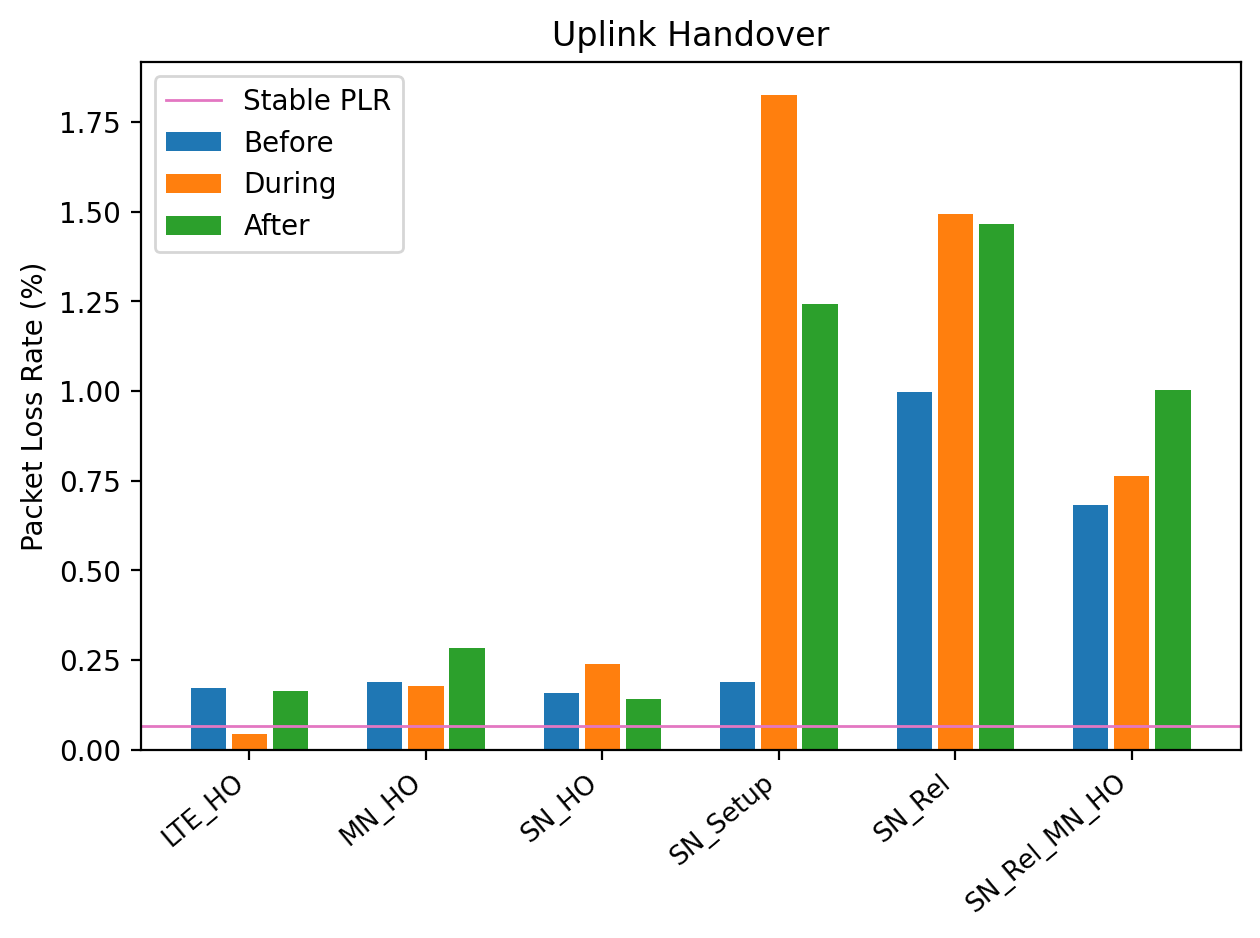

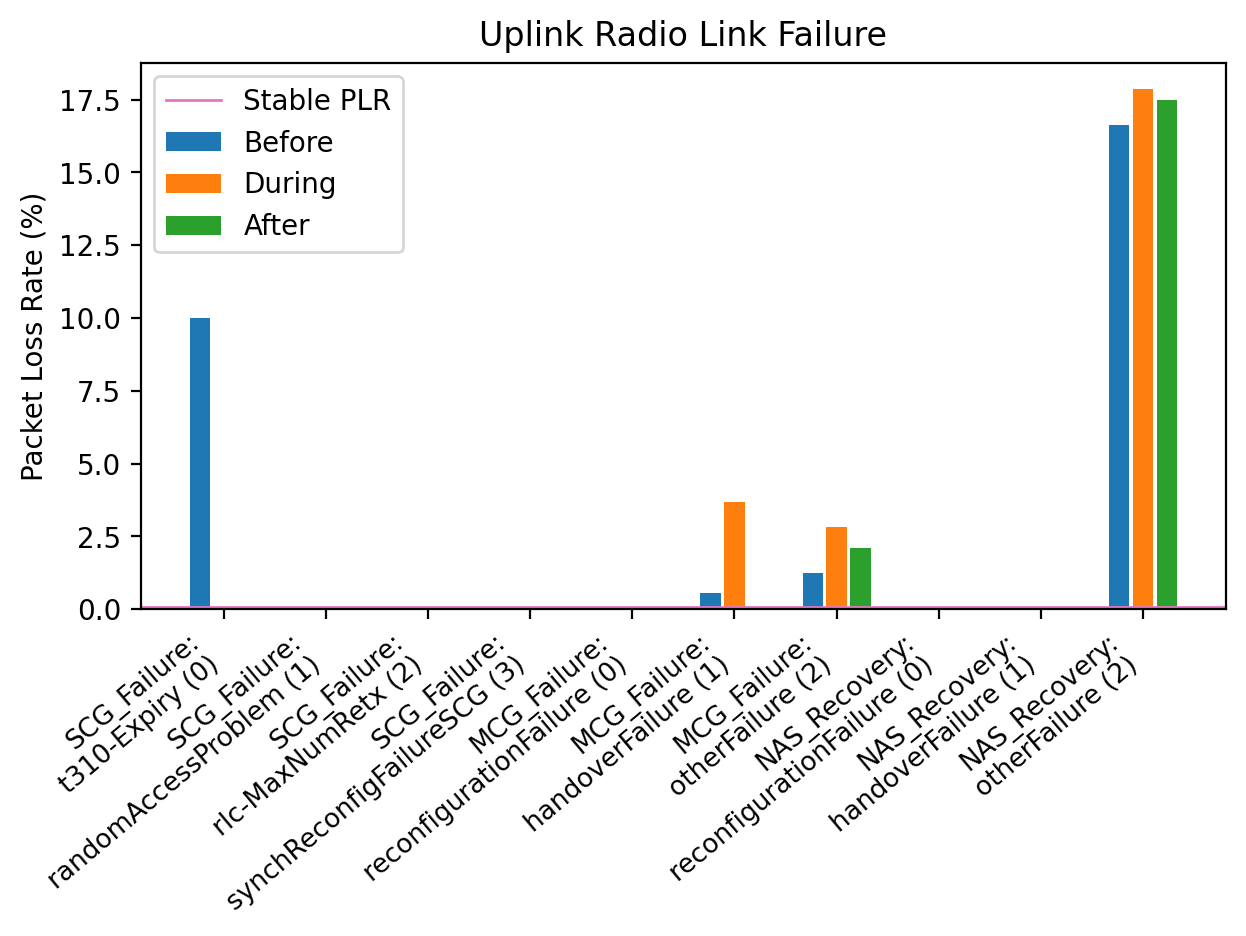

In [43]:
labels = ['LTE_HO','MN_HO','SN_HO','SN_Setup','SN_Rel','SN_Rel_MN_HO']
before_event_loss_rate = [DD[f'before_{tag}'][2] / (DD[f'before_{tag}'][1] + 1e-9) * 100 for tag in labels]
during_event_loss_rate = [DD[f'during_{tag}'][2] / (DD[f'during_{tag}'][1] + 1e-9) * 100 for tag in labels]
after_event_loss_rate = [DD[f'after_{tag}'][2] / (DD[f'after_{tag}'][1] + 1e-9) * 100 for tag in labels]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_loss_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_loss_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_loss_rate, width, label='After')
ax.axhline(DD['stable'][2] / (DD['stable'][1] + 1e-9) * 100, c = 'tab:pink', linewidth=1, label='Stable PLR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
ax.set_title('Uplink Handover')
ax.legend()

ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

# ax.set_ylim(top=round(max(classif_3_df['packet_loss_rate(%)'].iloc[:24]) + 0.2, 1))
# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()


labels=['SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)',
                            #   'SCG_Failure_scg-ReconfigFailure (4)','SCG_Failure_srb3-IntegrityFailure (5)','SCG_Failure_other-r16 (6)',
                              'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
                              'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']

# labels = ['SCG_Failure_t310-Expiry (0)','SCG_Failure_synchReconfigFailureSCG (3)',
#             'MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
#             'NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']
before_event_loss_rate = [DD[f'before_{tag}'][2] / (DD[f'before_{tag}'][1] + 1e-9) * 100 for tag in labels]
during_event_loss_rate = [DD[f'during_{tag}'][2] / (DD[f'during_{tag}'][1] + 1e-9) * 100 for tag in labels]
after_event_loss_rate = [DD[f'after_{tag}'][2] / (DD[f'after_{tag}'][1] + 1e-9) * 100 for tag in labels]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_loss_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_loss_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_loss_rate, width, label='After')
ax.axhline(DD['stable'][2] / (DD['stable'][1] + 1e-9) * 100, c = 'tab:pink', linewidth=1, label='Stable PLR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
ax.set_title('Uplink Radio Link Failure')
ax.legend()

labels = ['SCG_Failure:\nt310-Expiry (0)','SCG_Failure:\nrandomAccessProblem (1)','SCG_Failure:\nrlc-MaxNumRetx (2)','SCG_Failure:\nsynchReconfigFailureSCG (3)',
            'MCG_Failure:\nreconfigurationFailure (0)','MCG_Failure:\nhandoverFailure (1)','MCG_Failure:\notherFailure (2)',
            'NAS_Recovery:\nreconfigurationFailure (0)','NAS_Recovery:\nhandoverFailure (1)','NAS_Recovery:\notherFailure (2)']

# labels = ['SCG_Failure:\nt310-Expiry (0)','SCG_Failure:\nsynchReconfigFailureSCG (3)',
#             'MCG_Failure:\nhandoverFailure (1)','MCG_Failure:\notherFailure (2)',
#             'NAS_Recovery:\nhandoverFailure (1)','NAS_Recovery:\notherFailure (2)']

ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

# ax.set_ylim(top=round(max(classif_3_df['packet_loss_rate(%)'].iloc[:24]) + 0.2, 1))
# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()

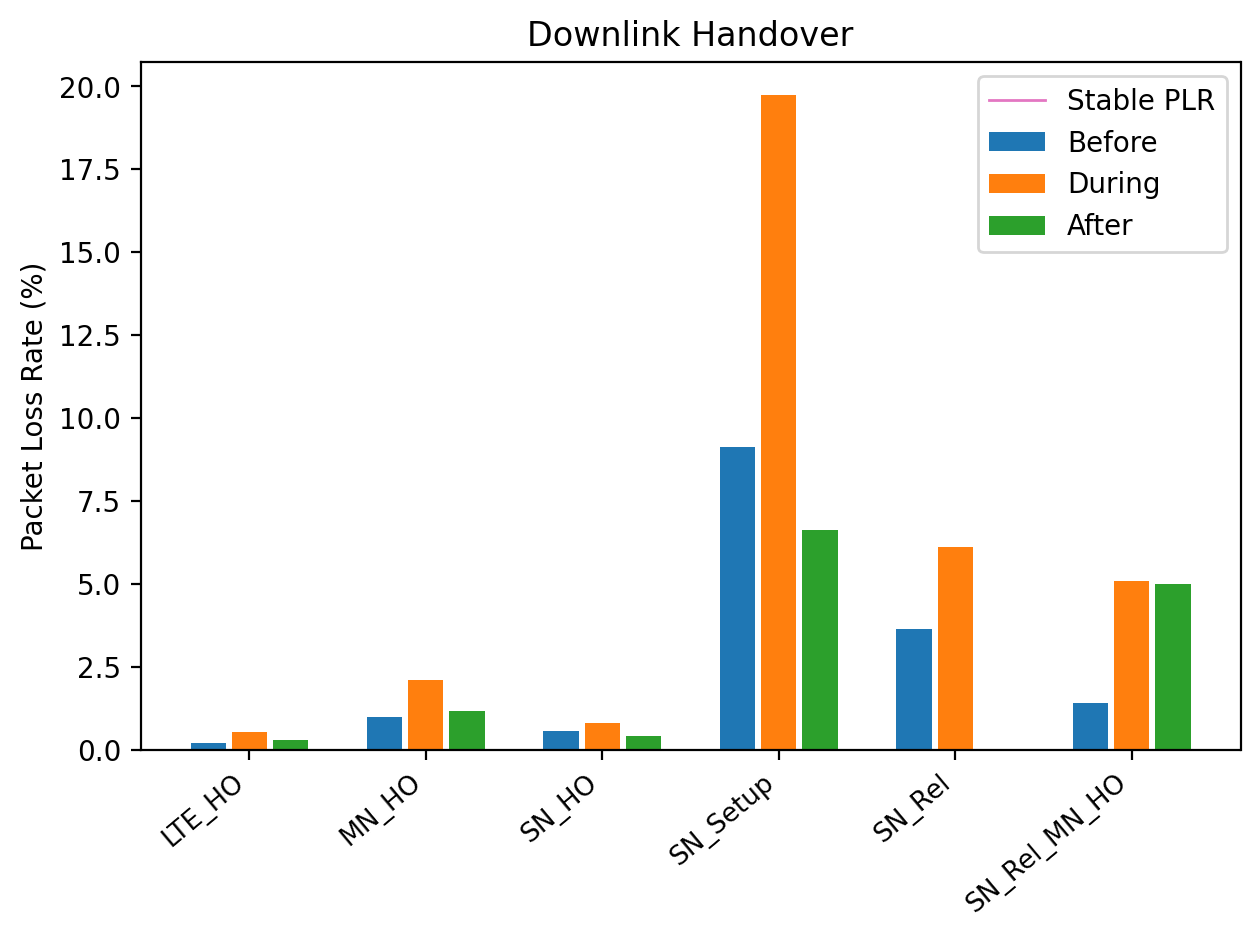

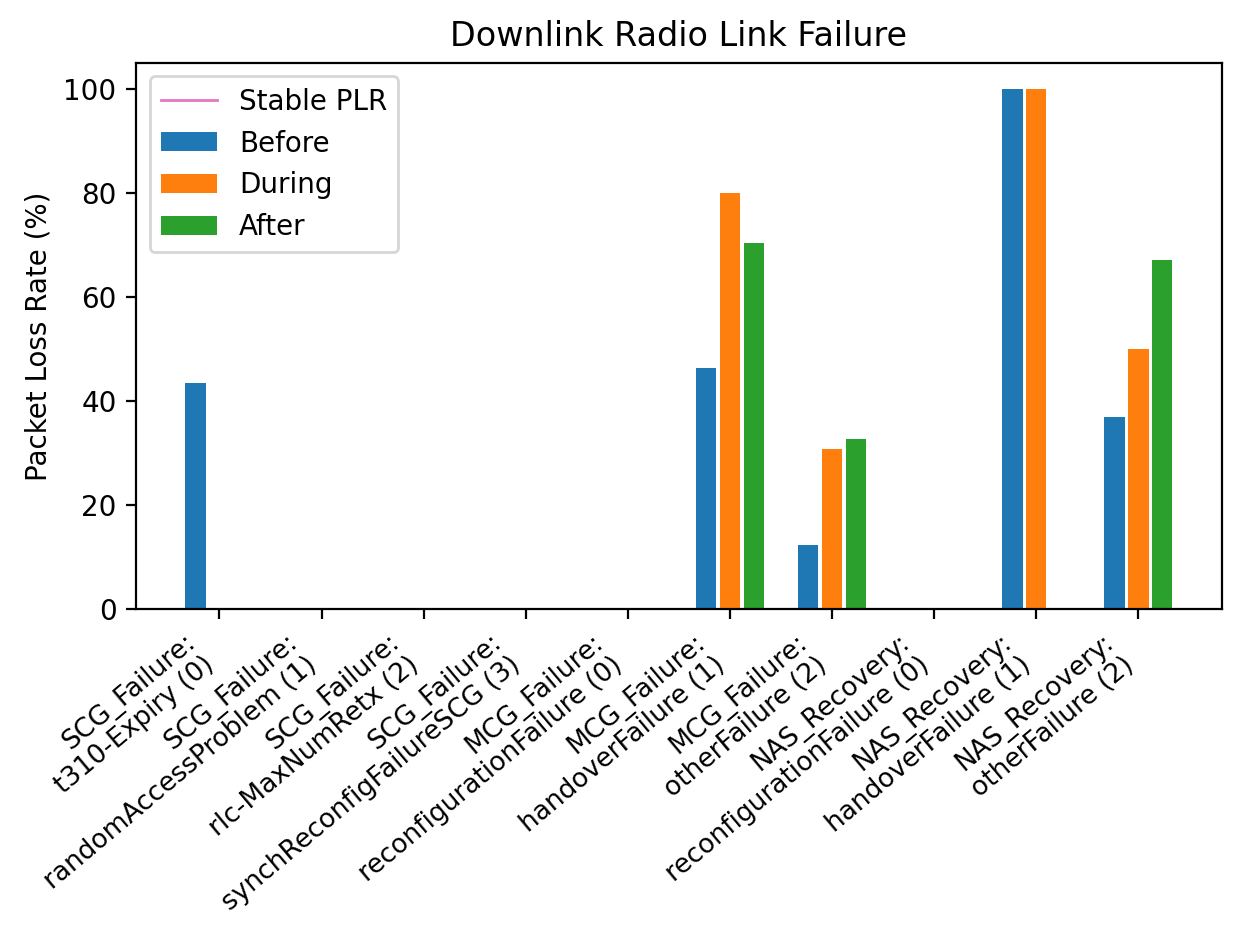

In [44]:
labels = ['LTE_HO','MN_HO','SN_HO','SN_Setup','SN_Rel','SN_Rel_MN_HO']
before_event_loss_rate = [DD[f'before_{tag}'][4] / (DD[f'before_{tag}'][3] + 1e-9) * 100 for tag in labels]
during_event_loss_rate = [DD[f'during_{tag}'][4] / (DD[f'during_{tag}'][3] + 1e-9) * 100 for tag in labels]
after_event_loss_rate = [DD[f'after_{tag}'][4] / (DD[f'after_{tag}'][3] + 1e-9) * 100 for tag in labels]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_loss_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_loss_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_loss_rate, width, label='After')
ax.axhline(DD['stable'][4] / (DD['stable'][3] + 1e-9) * 100, c = 'tab:pink', linewidth=1, label='Stable PLR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
ax.set_title('Downlink Handover')
ax.legend()

ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

# ax.set_ylim(top=round(max(classif_3_df['packet_loss_rate(%)'].iloc[:24]) + 0.2, 1))
# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()

labels=['SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)',
                            #   'SCG_Failure_scg-ReconfigFailure (4)','SCG_Failure_srb3-IntegrityFailure (5)','SCG_Failure_other-r16 (6)',
                              'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
                              'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']

# labels = ['SCG_Failure_t310-Expiry (0)','SCG_Failure_synchReconfigFailureSCG (3)',
#             'MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
#             'NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']

before_event_loss_rate = [DD[f'before_{tag}'][4] / (DD[f'before_{tag}'][3] + 1e-9) * 100 for tag in labels]
during_event_loss_rate = [DD[f'during_{tag}'][4] / (DD[f'during_{tag}'][3] + 1e-9) * 100 for tag in labels]
after_event_loss_rate = [DD[f'after_{tag}'][4] / (DD[f'after_{tag}'][3] + 1e-9) * 100 for tag in labels]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_loss_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_loss_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_loss_rate, width, label='After')
ax.axhline(DD['stable'][4] / (DD['stable'][3] + 1e-9) * 100, c = 'tab:pink', linewidth=1, label='Stable PLR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
ax.set_title('Downlink Radio Link Failure')
ax.legend()

labels = ['SCG_Failure:\nt310-Expiry (0)','SCG_Failure:\nrandomAccessProblem (1)','SCG_Failure:\nrlc-MaxNumRetx (2)','SCG_Failure:\nsynchReconfigFailureSCG (3)',
            'MCG_Failure:\nreconfigurationFailure (0)','MCG_Failure:\nhandoverFailure (1)','MCG_Failure:\notherFailure (2)',
            'NAS_Recovery:\nreconfigurationFailure (0)','NAS_Recovery:\nhandoverFailure (1)','NAS_Recovery:\notherFailure (2)']

# labels = ['SCG_Failure:\nt310-Expiry (0)','SCG_Failure:\nsynchReconfigFailureSCG (3)',
#             'MCG_Failure:\nhandoverFailure (1)','MCG_Failure:\notherFailure (2)',
#             'NAS_Recovery:\nhandoverFailure (1)','NAS_Recovery:\notherFailure (2)']

ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

# ax.set_ylim(top=round(max(classif_3_df['packet_loss_rate(%)'].iloc[:24]) + 0.2, 1))
# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()